In [ ]:
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Define the path to the Excel file relative to the notebook
excel_file_path = '../data/Muestra Proyecto Socios Formadores.xlsx'

# Load the data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Display the first few rows of the DataFrame to verify
df.head()

,Orden,Sucursal,FechaID,HoraLLegada,TurnoID,Turno,TurnoTipo,TurnoHoraInicio,TurnoHoraFin,TurnoMinutosEspera,TAPRecepcionMinutos,TAPRecepcionCaja
0,316483,COYOACAN,20240301,6,41684208,N015,Solicitar Estudios,06:02:44,06:13:23,NaN,NaN,NaN
1,316499,COYOACAN,20240301,6,41684414,N025,Solicitar Estudios,06:09:35,06:19:43,10.13,NaN,NaN
2,316515,COYOACAN,20240301,6,41684824,N038,Solicitar Estudios,06:18:16,06:30:42,12.43,NaN,NaN
3,316531,COYOACAN,20240301,6,41684679,P004,Triage,06:25:09,06:27:01,1.87,NaN,NaN
4,316547,COYOACAN,20240301,6,41685173,C011,Citado,06:35:09,06:37:47,2.63,NaN,NaN


In [3]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59650 entries, 0 to 59649
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Orden                59650 non-null  int64  
 1   Sucursal             59650 non-null  object 
 2   FechaID              59650 non-null  int64  
 3   HoraLLegada          59650 non-null  int64  
 4   TurnoID              59650 non-null  int64  
 5   Turno                59650 non-null  object 
 6   TurnoTipo            59650 non-null  object 
 7   TurnoHoraInicio      59650 non-null  object 
 8   TurnoHoraFin         59650 non-null  object 
 9   TurnoMinutosEspera   59649 non-null  float64
 10  TAPRecepcionMinutos  26316 non-null  float64
 11  TAPRecepcionCaja     26316 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 5.5+ MB


In [ ]:
# Percentage of nulls in TAPRecepcionMinutos column by Sucursal
df.groupby('Sucursal')['TAPRecepcionMinutos'].apply(
    lambda x: x.isna().sum() / x.size
).reset_index()

,Sucursal,TAPRecepcionMinutos
0,COYOACAN,1.000000
1,CULIACAN,0.136917
2,CULIACAN CAÑADAS,0.185835
3,CULIACAN COLEGIO MILITAR,0.090451
4,CULIACAN LA CONQUISTA,0.153556


In [5]:
# are there duplicates in the data?
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [6]:
# Since Coyoacan has 100% nulls, we'll exclude it from the analysis
clinics_df = df[df['Sucursal'] != 'COYOACAN'].copy()

# Exploración sobre el tiempo de espera en la fila para ser atendido en ventanilla

In [ ]:
# Convert time columns to strings, handling potential NaT or None values
clinics_df['TurnoHoraInicio_str'] = clinics_df['TurnoHoraInicio'].apply(
    lambda x: x.strftime('%H:%M:%S') 
    if pd.notna(x) and hasattr(x, 'strftime') else str(x)
)
clinics_df['TurnoHoraFin_str'] = clinics_df['TurnoHoraFin'].apply(
    lambda x: x.strftime('%H:%M:%S') 
    if pd.notna(x) and hasattr(x, 'strftime') else str(x)
)

# Combine FechaID (assuming YYYYMMDD format) and the time strings
# Convert FechaID to string first
clinics_df['FechaID_str'] = clinics_df['FechaID'].astype(str)

# Create combined datetime strings
start_datetime_str = clinics_df['FechaID_str'] + ' ' + clinics_df['TurnoHoraInicio_str']
end_datetime_str = clinics_df['FechaID_str'] + ' ' + clinics_df['TurnoHoraFin_str']

# Convert to datetime objects, coercing errors will turn unparseable entries into NaT
clinics_df['TurnoInicioDateTime'] = pd.to_datetime(
    start_datetime_str, 
    format='%Y%m%d %H:%M:%S', 
    errors='coerce'
)
clinics_df['TurnoFinDateTime'] = pd.to_datetime(
    end_datetime_str,
    format='%Y%m%d %H:%M:%S', 
    errors='coerce'
)

# Convert FechaID to datetime object separately
clinics_df['FechaID'] = pd.to_datetime(
    clinics_df['FechaID_str'], 
    format='%Y%m%d', 
    errors='coerce'
)

# Drop the intermediate string columns
clinics_df.drop(
    columns=[
        'FechaID_str', 'TurnoHoraInicio_str', 'TurnoHoraFin_str'
    ], 
    inplace=True
)

# Display the data types and first few rows to verify
print(clinics_df.info())
print(clinics_df[['FechaID', 'TurnoInicioDateTime', 'TurnoFinDateTime']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 30578 entries, 29072 to 59649
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Orden                30578 non-null  int64         
 1   Sucursal             30578 non-null  object        
 2   FechaID              30578 non-null  datetime64[ns]
 3   HoraLLegada          30578 non-null  int64         
 4   TurnoID              30578 non-null  int64         
 5   Turno                30578 non-null  object        
 6   TurnoTipo            30578 non-null  object        
 7   TurnoHoraInicio      30578 non-null  object        
 8   TurnoHoraFin         30578 non-null  object        
 9   TurnoMinutosEspera   30578 non-null  float64       
 10  TAPRecepcionMinutos  26316 non-null  float64       
 11  TAPRecepcionCaja     26316 non-null  float64       
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns]
 13  TurnoFinDateTime     30578 non-n

In [8]:
clinics_df['Turno'].apply(lambda x: x[0]).unique()

array(['P', 'N', 'C', 'F'], dtype=object)

At least there are 4 distinc major groups of "turnos".

As Salud Digna representative explained, "P" stands for priority.

In [9]:
clinics_df['TurnoGrupo'] = clinics_df['Turno'].apply(lambda x: x[0])

In [10]:
clinics_df['TurnoTipo']

29072     Estudio Pendiente
29073    Solicitar Estudios
29074                Citado
29075    Solicitar Estudios
29076    Solicitar Estudios
                ...        
59645     Citados sin folio
59646    Solicitar Estudios
59647    Solicitar Estudios
59648    Solicitar Estudios
59649    Solicitar Estudios
Name: TurnoTipo, Length: 30578, dtype: object

In [11]:
clinics_df[clinics_df['TurnoGrupo'] == 'F']['TurnoTipo'].unique()

array(['Folio Pagado', 'Cotizacion'], dtype=object)

In [12]:
clinics_df[clinics_df['TurnoGrupo'] == 'C']['TurnoTipo'].unique()

array(['Citado'], dtype=object)

In [13]:
clinics_df[clinics_df['TurnoGrupo'] == 'P']['TurnoTipo'].unique()


array(['Estudio Pendiente', 'Examen de la Vista', 'Triage',
       'Atención Empresas', 'Abono a Lentes', 'Entrega de Resultados'],
      dtype=object)

In [14]:
clinics_df[clinics_df['TurnoGrupo'] == 'N']['TurnoTipo'].unique()

array(['Solicitar Estudios', 'Citados sin folio'], dtype=object)

Observamos que los turnos con C son para personas que ya vienen con citas, los F son para personas con folio pagado, los P son los que tiene prioridad (según lo que nos dijo Salud Digna), y los N son los de turno "normal".

In [ ]:
clinics_df['WaitingTimeInLine'] = clinics_df['TurnoFinDateTime'] - clinics_df['TurnoInicioDateTime']

In [16]:
clinics_df['WaitingTimeInLine'].describe()

count                        30578
mean     0 days 00:06:55.121002027
std      0 days 00:11:37.730917810
min                0 days 00:00:00
25%                0 days 00:00:08
50%                0 days 00:02:00
75%                0 days 00:07:50
max                0 days 01:28:39
Name: WaitingTimeInLine, dtype: object

In [17]:
# Is there a difference in waiting times between the different groups?
clinics_df.groupby('TurnoGrupo')['WaitingTimeInLine'].agg('mean')

TurnoGrupo
C   0 days 00:01:25.159525979
F   0 days 00:01:13.912738214
N   0 days 00:08:54.758379257
P   0 days 00:02:00.697976878
Name: WaitingTimeInLine, dtype: timedelta64[ns]

Observamos que el tiempo de espera para los pacientes P es considerablemente menor que para los pacientes N. Lo mismo sucede con C y F. Esto es verdad para el conjunto de todas las sucursales de esta base de datos.

In [18]:
mean_waiting_times_per_sucursal = clinics_df.groupby(
    ['Sucursal', 'TurnoGrupo']
)['WaitingTimeInLine'].agg('mean')
mean_waiting_times_per_sucursal

Sucursal                  TurnoGrupo
CULIACAN                  C            0 days 00:01:02.713988919
                          F            0 days 00:01:04.925925925
                          N            0 days 00:04:31.787832864
                          P            0 days 00:01:30.888743455
CULIACAN CAÑADAS          C            0 days 00:01:24.765641569
                          F            0 days 00:01:05.629268292
                          N            0 days 00:06:07.717369136
                          P            0 days 00:01:52.910423452
CULIACAN COLEGIO MILITAR  C            0 days 00:02:01.741035856
                          F            0 days 00:01:35.948051948
                          N            0 days 00:18:45.296389437
                          P            0 days 00:02:40.516835016
CULIACAN LA CONQUISTA     C            0 days 00:01:59.841059602
                          F            0 days 00:01:39.291666666
                          N            0 days 00:10:2

Lo mismo se observa para cada sucursal en individual.

In [ ]:
# Convert the Series result back to a DataFrame for plotting
df_plot = mean_waiting_times_per_sucursal.reset_index()
df_plot.rename(
    columns={'WaitingTimeInLine': 'MeanWaitingTime'}, 
    inplace=True
) # Rename the value column for clarity

# Convert the timedelta mean waiting time to total seconds for plotting
df_plot['MeanWaitingTimeSeconds'] = df_plot['MeanWaitingTime'].dt.total_seconds()

# --- 2. Generate Heatmap ---
# Pivot the DataFrame to get 'Sucursal' as index, 'TurnoGrupo' as columns, and 'MeanWaitingTimeSeconds' as values
heatmap_data = df_plot.pivot(
    index='Sucursal', 
    columns='TurnoGrupo', 
    values='MeanWaitingTimeSeconds'
)

plt.figure(figsize=(10, 8)) # Adjust figure size as needed
# Use the heatmap_data based on seconds
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Mean Waiting Time Heatmap by Sucursal and TurnoGrupo', fontsize=16)
plt.xlabel('Turno', fontsize=12)
plt.ylabel('Sucursal', fontsize=12)
plt.tight_layout() # Adjust layout

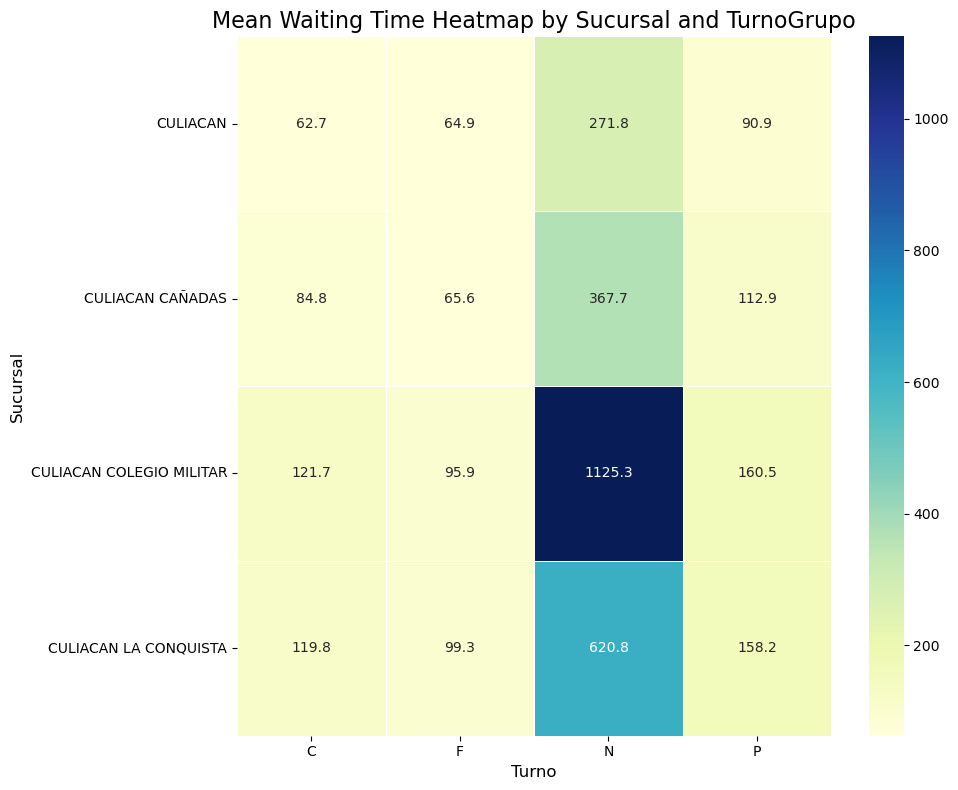

In [20]:
plt.show()

In [21]:
# Analyze by time of day
clinics_df['TurnoInicioDateTime'].dt.hour.unique()


array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  5],
      dtype=int32)

In [22]:
# Delete observations with hours where the clinics are closed
clinics_df['HourOfDay'] = clinics_df['TurnoInicioDateTime'].dt.hour
clinics_df = clinics_df[clinics_df['HourOfDay'].between(5, 20)]

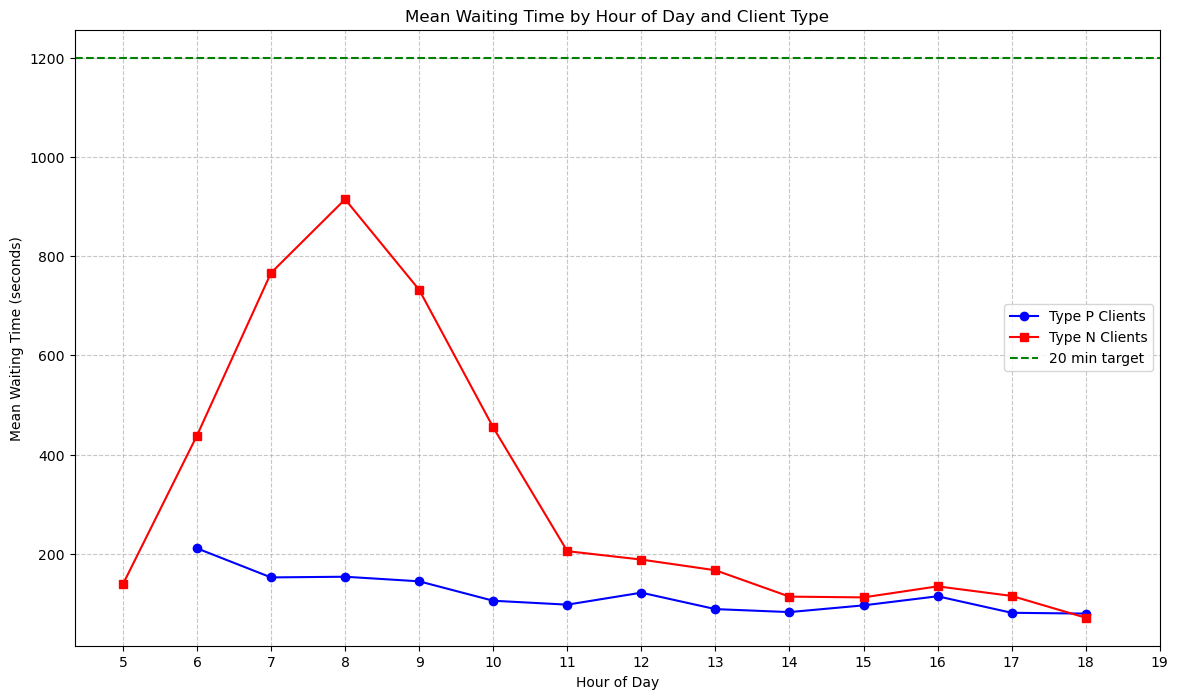

In [ ]:
# Group by hour and client type
hourly_stats = clinics_df.groupby(
    ['HourOfDay', 'TurnoGrupo']
)['WaitingTimeInLine'].agg([
    'mean', 'median', 'count', ('75%', lambda x: x.quantile(0.75)),
]).reset_index()

hourly_stats['MeanWaitingTimeSeconds'] = hourly_stats['mean'].dt.total_seconds()
# Plot waiting times by hour and client type
plt.figure(figsize=(14, 8))

# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['MeanWaitingTimeSeconds'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], 
    type_b['MeanWaitingTimeSeconds'], 
    's-', label='Type N Clients', color='red'
)

# Add a horizontal line at 20 minutes
plt.axhline(y=1200, color='green', linestyle='--', label='20 min target')

plt.title('Mean Waiting Time by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Waiting Time (seconds)')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos que los clientes con turnos N en promedio esperan más que los clientes con turnos P sin importar la hora del día. Esto es verdadero para el conjunto de todas las sucursales.

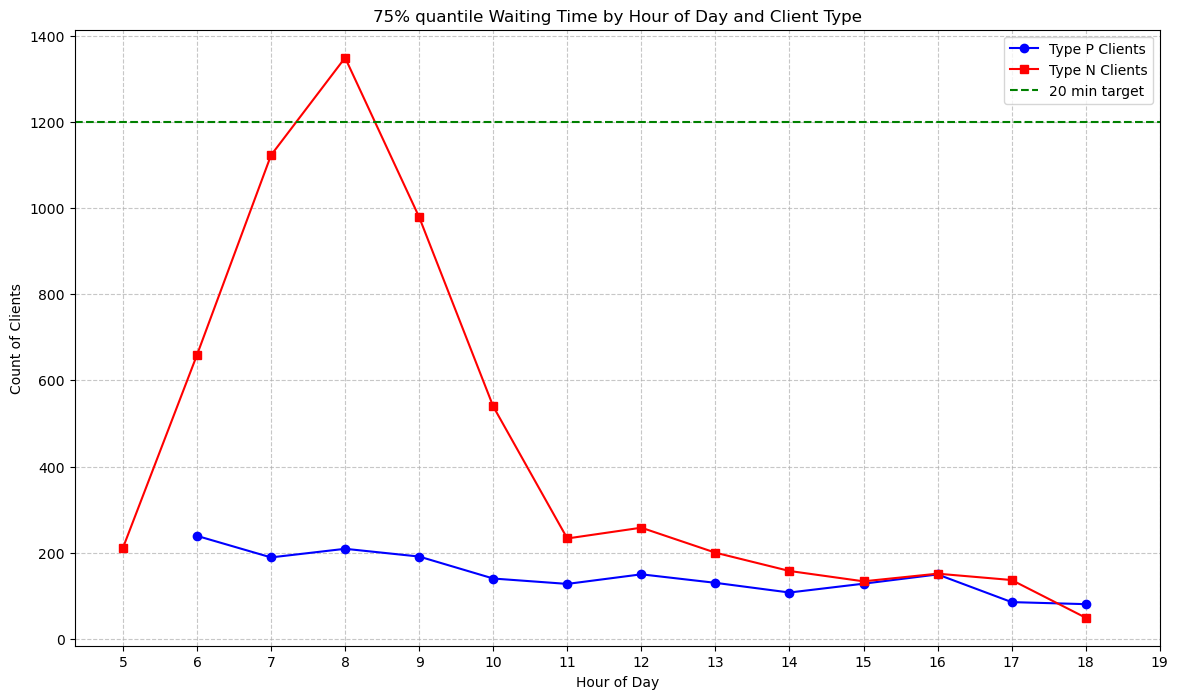

In [ ]:
# Plot count of types of clientes each hour
plt.figure(figsize=(14, 8))
hourly_stats['75%WaitingTimeSeconds'] = hourly_stats['75%'].dt.total_seconds()
# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['75%WaitingTimeSeconds'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], 
    type_b['75%WaitingTimeSeconds'], 
    's-', label='Type N Clients', color='red'
)

# Add a horizontal line at 20 minutes
plt.axhline(y=1200, color='green', linestyle='--', label='20 min target')

plt.title('75% quantile Waiting Time by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Clients')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos el mismo comportamiento para el quantil 0.75. 

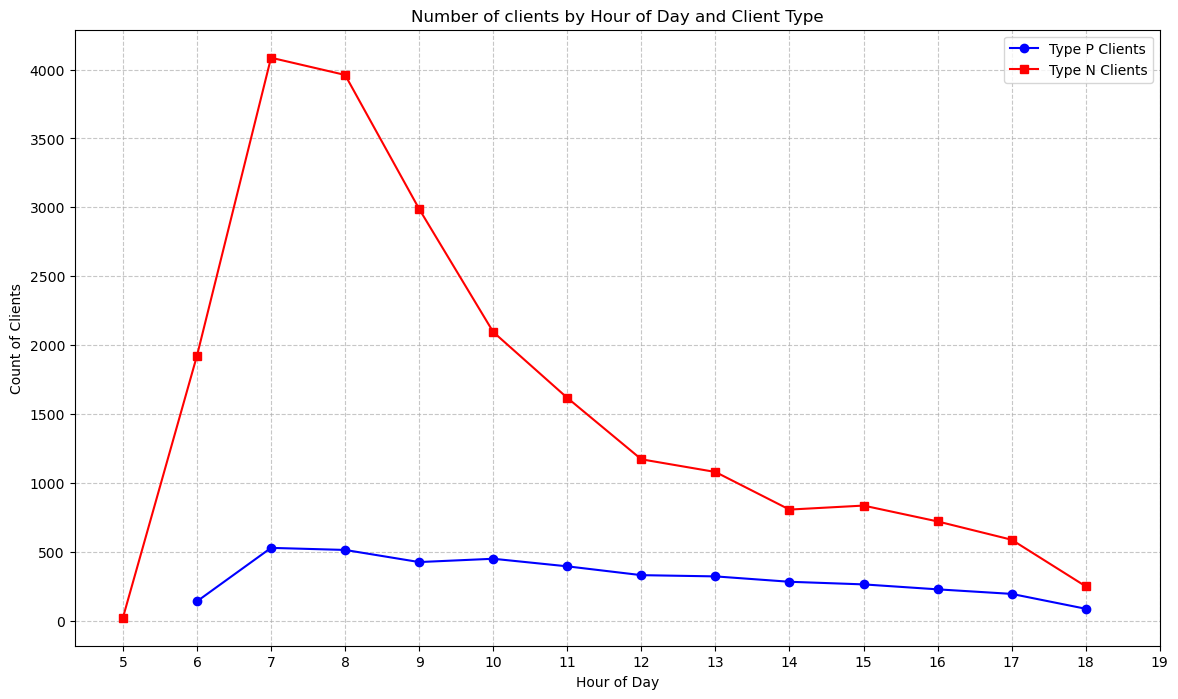

In [ ]:
b# Plot count of types of clientes each hour
plt.figure(figsize=(14, 8))

# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['count'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], type_b['count'], 
    's-', label='Type N Clients', color='red'
)

plt.title('Number of clients by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Clients')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos como a cualquier hora del día hay más clientes tipo N que tipo P. Esto es verdadero para el conjunto de todas las sucursales en la base de datos.

# Exploración sobre el tiempo de atención en ventanilla

In [ ]:
clinics_df['TimeInService'] = pd.to_timedelta(clinics_df['TAPRecepcionMinutos'], unit='m')

In [46]:
clinics_df.groupby('TurnoGrupo')['TimeInService'].agg('mean')

TurnoGrupo
C   0 days 00:03:41.307112140
F   0 days 00:03:26.737333333
N   0 days 00:03:38.923620215
P   0 days 00:02:41.091113028
Name: TimeInService, dtype: timedelta64[ns]

In [40]:
clinics_df['TAPRecepcionMinutos'] 

29072    0.58
29073    4.42
29074    2.97
29075    1.68
29076    4.68
         ... 
59645    1.38
59646     NaN
59647     NaN
59648    3.97
59649     NaN
Name: TAPRecepcionMinutos, Length: 30578, dtype: float64